In [1]:
import pandas as pd
import numpy as np
import zipfile

## Import Data

In [2]:
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

In [3]:
# with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')

In [4]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

## Clean Data and Filter For Needed Info

### Property Sales

In [5]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [6]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
2,330395,1610,335000,06/07/2012
3,675260,940,209950,03/06/1998
5,269549,190,154950,07/23/2000
6,638580,110,190000,07/14/2015
8,321165,50,2100000,05/10/2004


### Parcel

In [7]:
# parcel.info()

In [8]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'PropType', 'SqFtLot', 'WfntLocation',
                 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances',
                 'MtRainier', 'Olympics', 'Cascades', 'PugetSound', 'LakeWashington',
                 'LakeSammamish', 'SmallLakeRiverCreek','SeattleSkyline']]

In [9]:
#Filter for R - residential and K - Condos
parcel = parcel[(parcel['PropType']=='R') | (parcel['PropType']=='K')]

In [10]:
# Seattle Sky Line column has multiple values so changing to 1 and 0
parcel['SeattleSkyline'] = [1 if i>0 else 0 for i in parcel.SeattleSkyline]

In [11]:
#Create Nuisances Column combining all nuisances and map 1, 0 values to Y and N for PowerLines and Other Nuisances
parcel['Nuisances'] = 'No Nuisances'
parcel.loc[(parcel['TrafficNoise']>0), 'Nuisances'] = 'Traffic Noise'
parcel.loc[(parcel['AirportNoise']>0), 'Nuisances'] = 'Airport Noise'
parcel.loc[(parcel['PowerLines']=='Y'), 'Nuisances'] = 'Power Lines'
parcel.loc[(parcel['OtherNuisances']=='Y'), 'Nuisances'] = 'Other Nuisances'
parcel['PowerLines'] = parcel['PowerLines'].map({'Y' : 1, 'N' : 0})
parcel['OtherNuisances'] = parcel['OtherNuisances'].map({'Y' : 1, 'N' : 0})
parcel['Has_Nuisance'] = [0 if n == 'No Nuisances' else 1 for n in parcel['Nuisances']]

# Drop Unecessary columns from parcel
parcel = parcel.drop(['PropType', 'AirportNoise'], axis='columns')

In [12]:
# WFNTLOCATION map to contain water names and create Is_Saterfront column
# Waterfront location (Source: King County Assessments)
# Value	Definition
# 0	Unknown
# 1	Duwamish
# 2	Elliott Bay
# 3	Puget Sound
# 4	Lake Union
# 5	Ship Canal
# 6	Lake Washington
# 7	Lake Sammamish
# 8	Other lake
# 9	River or slough

parcel['WaterFrontLocation'] = parcel.WfntLocation.map({0 : 'None', 1 : 'Duwamish', 2 : 'Elliott Bay', 3 : 'Puget Sound', 4 : 'Lake Union',
                     5 : 'Ship Canal',  6 : 'Lake Washington', 7 : 'Lake Sammamish', 8 : 'Other lake', 9 : 'River or slough'})
parcel['Is_WaterFrontLocation'] = [1 if i>0 else 0 for i in parcel.WfntLocation]
parcel=parcel.drop('WfntLocation', axis='columns')

### Residential Buiding

In [13]:
# residential_building.info()

In [14]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'ZipCode', 'SqFtTotLiving', 'SqFtOpenPorch',
                                             'SqFtEnclosedPorch', 'SqFtFinBasement', 'SqFtGarageAttached',
                                             'BldgGrade', 'SqFtDeck']]

In [15]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]
residential_building['Has_OpenPorch'] = [1  if p>0 else 0 for p in residential_building['SqFtOpenPorch']]
residential_building['Has_EnclosedPorch'] = [1  if p>0 else 0 for p in residential_building['SqFtEnclosedPorch']]

# Drop Unecessary columns from residential_building
residential_building = residential_building.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis='columns')

In [16]:
# Create a column Has_Deck
residential_building['Has_Deck'] = [1  if d>0 else 0 for d in residential_building['SqFtDeck']]

# Create a column Has_Finished_Basement
residential_building['Has_Finished_Basement'] = [1  if b>0 else 0 for b in residential_building['SqFtFinBasement']]

# Create a column Has_Attached_Garage
residential_building['Has_Attached_Garage'] = [1  if g>0 else 0 for g in residential_building['SqFtGarageAttached']]

# Drop Unecessary columns from residential_building
residential_building = residential_building.drop(['SqFtDeck', 'SqFtFinBasement', 'SqFtGarageAttached'], axis='columns')

In [17]:
# Builing Grade column - remap to make more sense according to description
# 1 : 'Poor'
# 2 : 'Low',
# 3 : 'Fair'
# 4 : 'Low-Average'
# 5 : 'Average'
# 6 : 'Good'
# 7 : 'Better'
# 8 : 'Very Good'
# 9 : 'Cabin',
# 10 : 'Excellent'
# 11 : 'Luxury'
# 12 : 'Mansion'

residential_building['BldgGrade'] = residential_building.BldgGrade.map({3 : 1, 4 : 2, 5 : 3,  6 : 4, 7 : 5, 8 : 6, 9 : 7, 10 : 8,
                                    1: 9, 11 : 10, 12 : 11, 13 : 12})

### Merge Property Sales, parcel, and residential building data

In [18]:
# Join all the tables on Major, Minor
merged_tables = (parcel.merge(real_property_sales, on = ['Major', 'Minor'])).merge(residential_building, on = ['Major', 'Minor']).drop_duplicates()

# Change dates to date time format
merged_tables[['Major', 'SqFtLot']].head(20)
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [19]:
merged_tables.shape

(991786, 29)

In [20]:
#Keeping only the most recent Sale_Price For each residence
merged_tables = merged_tables.sort_values(by=['Major', 'DocumentDate'])
merged_tables.drop_duplicates(subset=['Major', 'Minor'], keep='last', inplace=True)
merged_tables.shape

(447186, 29)

In [21]:
# Filtering for only 2019 data
start_date = "2019-1-1"
end_date = "2019-12-31"
merged_tables = merged_tables.loc[(merged_tables["DocumentDate"] >= start_date) & (merged_tables["DocumentDate"] <= end_date)]

merged_tables.shape

(28009, 29)

In [22]:
# change dataframe name to df to make life easier
df = merged_tables

In [23]:
# reorder Columns
df = df[['Major', 'Minor', 'ZipCode', 'DocumentDate', 'SalePrice', 'SqFtLot', 'SqFtTotLiving',
         'Nuisances', 'Has_Nuisance', 'TrafficNoise', 'PowerLines', 'OtherNuisances',
         'Is_WaterFrontLocation', 'WaterFrontLocation', 'Has_Porch', 'Has_OpenPorch',
         'Has_EnclosedPorch', 'MtRainier', 'Olympics', 'Cascades', 'SeattleSkyline',
         'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'BldgGrade', 'Has_Deck',
         'Has_Finished_Basement', 'Has_Attached_Garage']]

In [24]:
# Rename Columns
df.rename(columns={'MtRainier': 'View_MtRainier', 'Olympics': 'View_Olympics', 'Cascades': 'View_Cascades',
                   'PugetSound': 'View_PugetSound', 'LakeWashington': 'View_LakeWashington',
                   'LakeSammamish': 'View_LakeSammamish','SmallLakeRiverCreek': 'View_SmallLakeRiverCreek',}, inplace = True)

In [25]:
# Clean zipcode column

df['ZipCode'] = df['ZipCode'].astype('str')
df['ZipCode'] = [None if len(code)<5 else code for code in df['ZipCode']]
df = df.sort_values(by=['Major', 'ZipCode'])
df['ZipCode'] = df['ZipCode'].fillna(method='ffill')
df['ZipCode'] = [code[0:5] for code in df['ZipCode']]

## Graphical EDA

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

### Plot some distributions and box plots and Remove Outliers

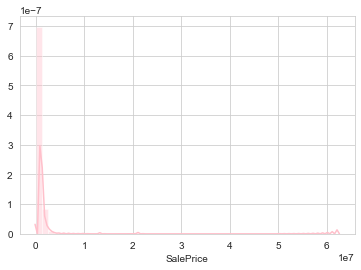

In [51]:
# Can see this is extremely scewed and data outliers need to be treated
sns.distplot(df['SalePrice'], color = "Pink");

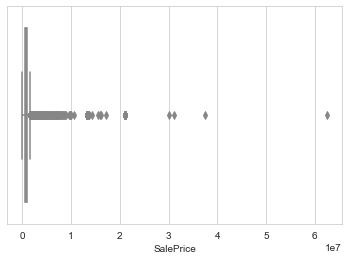

In [52]:
# Cant even see the pink of the box and we can clearly see one particularly large outlier
sns.boxplot(df['SalePrice'], color = "Pink");

In [53]:
# Treating the outliers to include price range of 10000 to 10050000
df2 = df[df['SalePrice'].between(df['SalePrice'].quantile(.004), df['SalePrice'].quantile(.9961))]

In [54]:
print("Sales Price min: ", df2['SalePrice'].min(),
      "\nSales Price max: ", df2['SalePrice'].max(),
      "\nSales Price max: ", df2['SalePrice'].mean())

Sales Price min:  10000 
Sales Price max:  10050000 
Sales Price max:  810713.3477290722


FileNotFoundError: [Errno 2] No such file or directory: './../reports/figures/Sales_Dist.png'

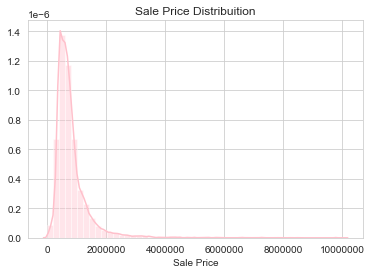

In [55]:
#Plot Sale Price to see if it looks better after treating the outliers
chart = sns.distplot(df2['SalePrice'], color = "Pink")
chart.set(xlabel='Sale Price', title='Sale Price Distribuition')
plt.ticklabel_format(style='plain', axis='x');
plt.savefig("./../reports/figures/Sales_Dist.png", bbox_inches='tight')

In [ ]:
sns.boxplot(df2['SalePrice'], color = "Pink");

In [ ]:
# Clean index
df2=df2.reset_index(drop=True)

In [ ]:
# Find what Features correlate most with Sale Price and plot some initial EDA visuals
corr_matrix = df2.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))

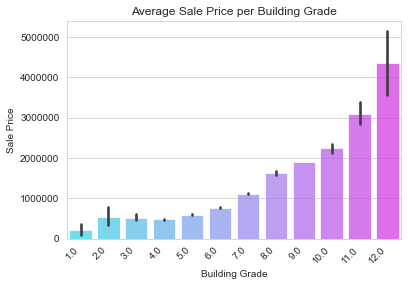

In [56]:
# Building Grade had the highest correlation with Sales Price so we'll start with that
fig = sns.barplot('BldgGrade', 'SalePrice', data=df2, palette="cool", alpha = .7)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.set(xlabel='Building Grade', ylabel='Sale Price', title='Average Sale Price per Building Grade')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/Building_Grade.png", bbox_inches='tight')

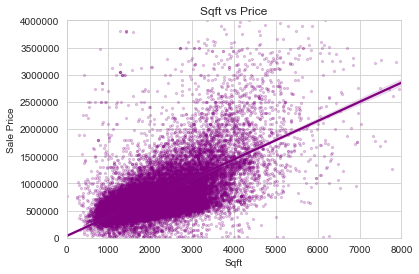

In [57]:
# Scatter plot of Sq Feet vs Sale Price
chart = sns.regplot(x='SqFtTotLiving', y='SalePrice', data=df2,  color = "Purple", scatter_kws={'alpha':0.2, 's': 5})
chart.set(xlabel='Sqft', ylabel='Sale Price', title='Sqft vs Price')
plt.ticklabel_format(style='plain', axis='y');
chart.set(xlim=(0, 8000), ylim=(0, 4000000))
plt.savefig("../../reports/figures/sqftvsPrice.png", bbox_inches='tight')

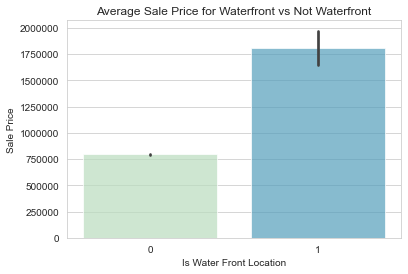

In [58]:
chart = sns.barplot(df2.Is_WaterFrontLocation, df2.SalePrice, palette="GnBu", alpha = .7)
chart.set(xlabel='Is Water Front Location', ylabel='Sale Price', title='Average Sale Price for Waterfront vs Not Waterfront')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/Is_WaterFront_Loc.png", bbox_inches='tight')

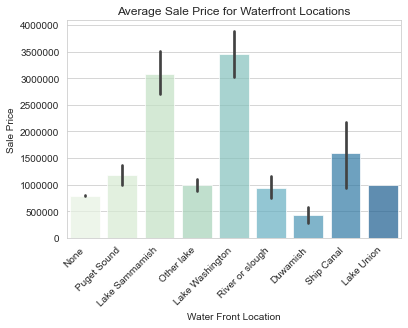

In [59]:
chart = sns.barplot(df2.WaterFrontLocation, df2.SalePrice, palette="GnBu", alpha = .7)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel='Water Front Location', ylabel='Sale Price', title='Average Sale Price for Waterfront Locations')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/WaterFront_Loc.png", bbox_inches='tight')

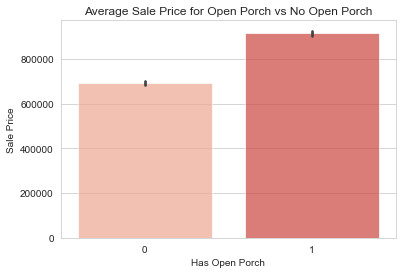

In [60]:
fig = sns.barplot(df2['Has_OpenPorch'], df2['SalePrice'], palette="Reds", alpha = .7);
fig.set(xlabel='Has Open Porch', ylabel='Sale Price', title='Average Sale Price for Open Porch vs No Open Porch')
plt.ticklabel_format(style='plain', axis='y')
plt.savefig("../../reports/figures/Has_Open_Porch.png", bbox_inches='tight');

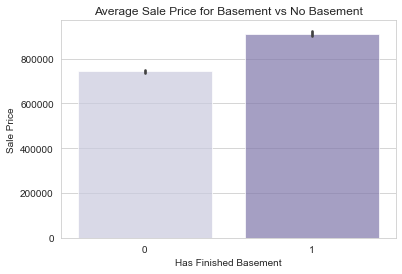

In [61]:
fig = sns.barplot(df2['Has_Finished_Basement'], df2['SalePrice'], palette="Purples",  alpha = .7)
fig.set(xlabel='Has Finished Basement', ylabel='Sale Price', title='Average Sale Price for Basement vs No Basement')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/Has_Finished_Basement.png", bbox_inches='tight')

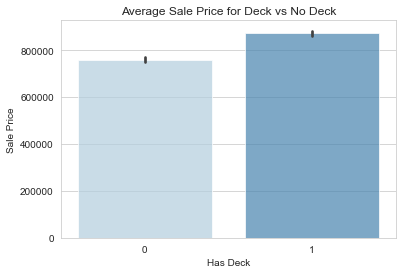

In [62]:
fig = sns.barplot(df2['Has_Deck'], df2['SalePrice'], palette="Blues",  alpha = .7)
fig.set(xlabel='Has Deck', ylabel='Sale Price', title='Average Sale Price for Deck vs No Deck')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/Has_Deck.png", bbox_inches='tight')

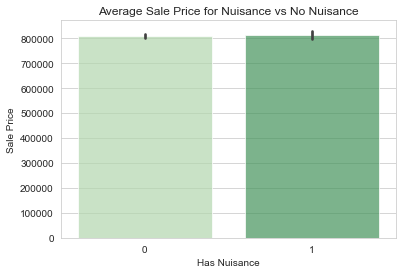

In [63]:
fig = sns.barplot(df2['Has_Nuisance'], df2['SalePrice'], palette="Greens",  alpha = .7)
fig.set(xlabel='Has Nuisance', ylabel='Sale Price', title='Average Sale Price for Nuisance vs No Nuisance')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/Nuisances.png", bbox_inches='tight')

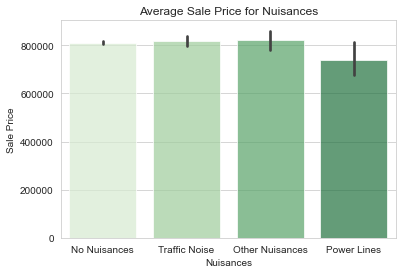

In [64]:
fig = sns.barplot(df2['Nuisances'], df2['SalePrice'], palette="Greens",  alpha = .7)
fig.set(xlabel='Nuisances', ylabel='Sale Price', title='Average Sale Price for Nuisances')
plt.ticklabel_format(style='plain', axis='y');
plt.savefig("../../reports/figures/Power_Lines.png", bbox_inches='tight')

In [65]:
df2.to_csv('../../data/clean/KingCountyHousingData.csv')